# Volume Variance Relations for Scaling Statistics

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

This is a tutorial for / demonstration of **Volume Variance Relations**.

* all spatial statistics have an implicit scale assumption
* for example, as the scale, support size, increases the variance reduces

**YouTube Lecture**: check out my lecture on:
        
* [Scale](https://youtu.be/suWCmal03Rg?si=XEtIlBlgP175qkUb)
* [Dispersion Variance](https://youtu.be/UI81msM0wXQ?si=Ige9n70STMfC6kwU)
* [Scaling Statistics](https://youtu.be/MM7Tn8TU5Bk?si=0GVOKJ6nYx1cib28)
    
For your convenience here's a summary of salient points.

#### Dispersion Variance and Volume Variance Relations

**Volume-variance Relations** stats that as the volume support increases the variance reduces

Predicting this behavior is central to handling multiple scales of data and estimation.

Scale Observations:

* The mean does not change.

* The variance changes, known as volume-variance relations.

* There may be shape change (we will not tackle that here). Best practice is to check shape change empirically. It is common to assume no shape change (affine distribution correction) or to use a simple shape change model (indirect lognormal correction)

* The variance reduction in the distribution is inversely proportional to the range of spatial continuity.  

* Over common changes in scale this impact may be significant. 

* We need a model to predict this change.

Scale Change Models:

**Empirical** - build a small scale, high resolution model and scale it up. This requires a model for spatial feature scale up. For example, averages the small scale cells within the larger scale assues linear averaging. There is a more flexible model known as power law averaging.

$$
z_V = \left[ \frac{1}{n} \sum z_v^{\omega} \right] ^{\frac{1}{\omega}}
$$

where $\omega$ is the power of averaging. For example:

* $\omega = 1$ is a regular linear averaging
* $\omega = -1$ is a harmonic averaging 
* $\omega = 0$ is a geometric averaging (this is proved in the limit as $\omega \rightarrow 0$)

**Model** - directly adjust the statistics for change in scale. For example, under the assumption of linear averaging and a stationary variogram and variance:

$$
f = 1 - \frac{\overline{\gamma}(v,v)}{\sigma^2}
$$

where $f$ is variance reduction factor,

$$
f = \frac{D^2(v,V)}{D^2(\cdot,V)} = \frac{D^2(v,V)}{\sigma^2}
$$

in other words, $f$ is the ratio of the variance at scale $v$ to the variance at the original data point support scale.

Here I provide simple empirical, numerical demonstrations of the impact of change on scale on variance and the impact of spatial continuity on this effect. 

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))

GeostatsPy version: 0.0.71


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # supress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrys for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
from matplotlib import gridspec                               # custom subplots
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
from IPython.utils import io                                  # mute output from simulation
cmap = plt.cm.inferno                                         # color map for plotting 

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

We use GeostatsPy, but we need a new upscale (linear averaging) method and a plotting method that does not interpolate. I will add these to GeostatsPy shortly.

In [3]:
def getindex(nc,cmn,csiz,loc):                                # take location and grid and find the cell
    ic = min(int((loc - cmn) / csiz), nc - 1)
    return ic

def upscale(model,new_nx,new_ny):                             # scale up model with linear averaging
    ny, nx = model.shape
    new_xsiz = nx/new_nx; new_xmn = new_xsiz * 0.5
    new_ysiz = ny/new_ny; new_ymn = new_ysiz * 0.5
    new_model = np.zeros((new_ny,new_nx)); count = np.zeros((new_ny,new_nx))
    for iy in range(0,ny):
        yloc = iy+0.5
        new_iy = getindex(new_ny,new_ymn,new_ysiz,yloc)
        for ix in range(0,nx):
            xloc = ix+0.5
            new_ix = getindex(new_nx,new_xmn,new_xsiz,xloc)
            new_model[new_iy,new_ix] = new_model[new_iy,new_ix] + model[iy,ix] 
            count[new_iy,new_ix] = count[new_iy,new_ix] + 1 
    for iny in range(0,new_ny):
        for inx in range(0,new_nx):
            if count[iny,inx] > 0:
                new_model[iny,inx] = new_model[iny,inx] / count[iny,inx]
    return new_model

def cellplt_st(array,xmin,xmax,ymin,ymax,vmin,vmax,title,xlabel,ylabel,vlabel,cmap):
    im = plt.imshow(array,cmap,vmin=vmin,vmax=vmax,extent=[xmin, xmax, ymin, ymax])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    #plt.clim(vmin,vmax)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(vlabel, rotation=270, labelpad=20) 


#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [4]:
#os.chdir("C:/PGE383")                                        # set the working directory

You will have to update the part in quotes with your own working directory and the format is different on a Mac (e.g. "~/PGE"). 

#### Spatial Data

Make dummy data with a reference distribution, but outside the area of interest for unconditional realizations.

In [5]:
nd = 100                                                      # number of data
df = pd.DataFrame(data = np.random.normal(loc=0.1,scale = 0.03,size=nd),columns=['Porosity'])
df['X'] = np.full(nd,-99999); df['Y'] = np.full(nd,-99999)
df.head()

,Porosity,X,Y
0,0.075302,-99999,-99999
1,0.117356,-99999,-99999
2,0.145010,-99999,-99999
3,0.087306,-99999,-99999
4,0.110071,-99999,-99999


##### Set the Spatial Parameters

The following are the basic parameters for the experiment.  This includes the number of cells in the 2D regular grid, the cell size (step) and the x and y min and max along with the color scheme.

In [6]:
nx = 100; ny = 100; xsiz = 100; ysiz = 100                        # grid number of cells and cell size
xmin = 0.0; ymin = 0.0;                                           # grid origin
xmax = xmin + nx * ysiz; ymax = ymin + ny * xsiz                  # calculate the extent of model
xmn = xmin + 0.5 * xsiz; ymn = ymin + 0.5 * ysiz                  # grid origin, lower left corner

pormin = 0.05; pormax = 0.22                                      # set feature min and max for colorbars
permmin = 0.0; permmax = 700.0

vmin = 0.0; vmax = 0.2                                            # property min and max
tmin = -999; tmax = 999                                           # trimming limits

ndmin = 0; ndmax = 10                                             # set minimum and maximum number of data

#### Numerical Scale Up with Two Models

Let's build two models and scale them up.

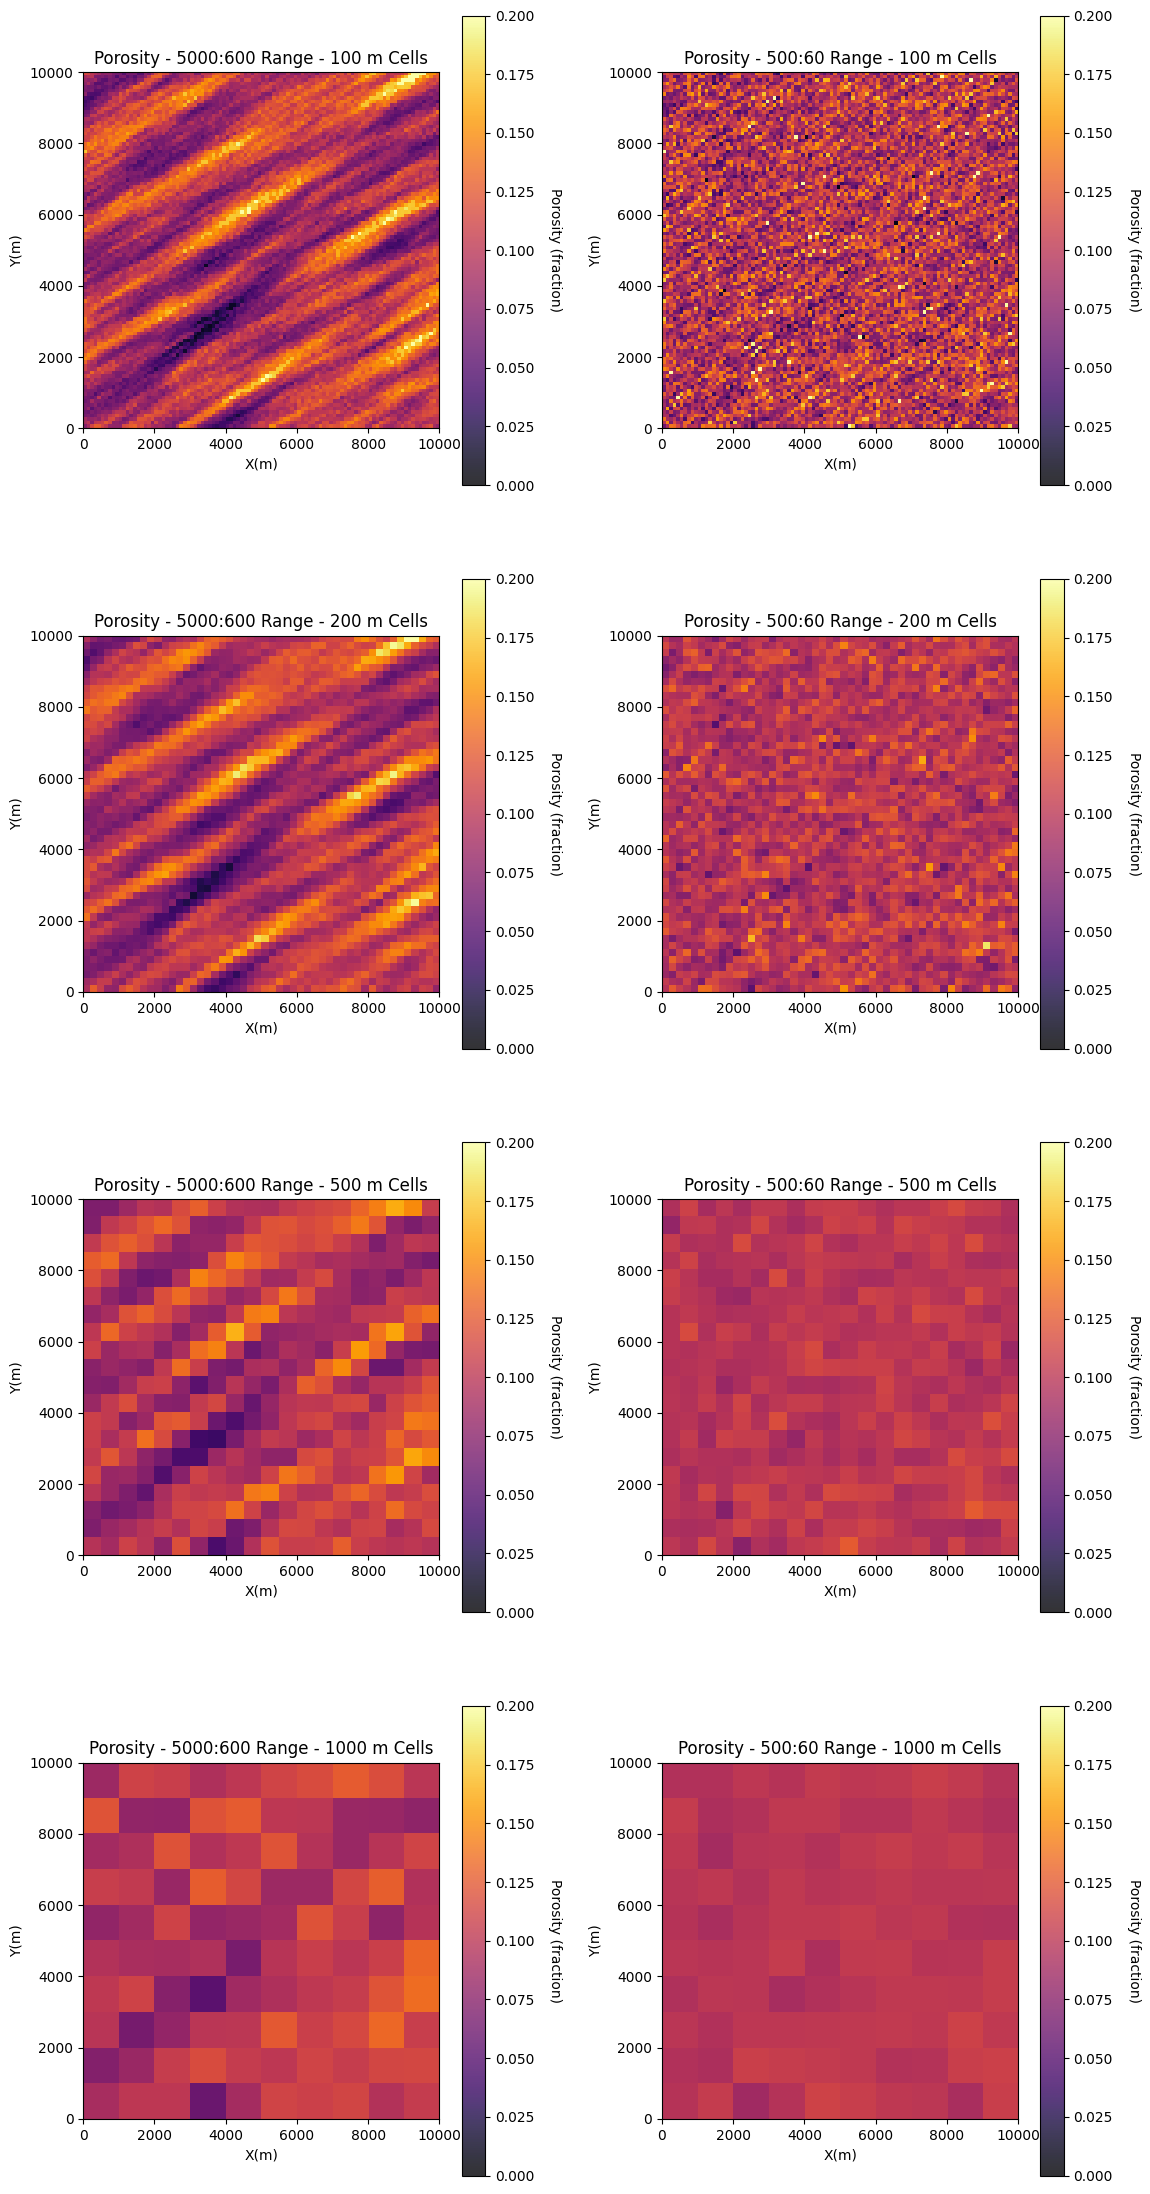

In [7]:
%%capture --no-display  

range_maj1 = 5000; range_min1 = 600
range_maj2 = 500; range_min2 = 60

vario1 = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=range_maj1,hmin1=range_min1)

sim1 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario1)[0]

sim1 = GSLIB.affine(sim1,.1,0.03)                                 # correct the distribution to a target mean and standard deviation.

vario2 = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=60.0,hmaj1=range_maj2,hmin1=range_min2)

sim2 = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,ktype=0,colocorr=0.0,sec_map=0,vario=vario2)[0]

sim2 = GSLIB.affine(sim2,.1,0.03)                                 # correct the distribution to a target mean and standard deviation.

plt.subplot(421)
GSLIB.pixelplt_st(sim1,xmin,xmax,ymin,ymax,xsiz,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 100 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(422)
GSLIB.pixelplt_st(sim2,xmin,xmax,ymin,ymax,xsiz,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 100 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

mid = upscale(sim1,new_nx = 50,new_ny = 50)
mid2 = upscale(sim2,new_nx = 50,new_ny = 50)

plt.subplot(423)
GSLIB.pixelplt_st(mid,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 200 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(424)
GSLIB.pixelplt_st(mid2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 200 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

midb = upscale(sim1,new_nx = 20,new_ny = 20)
midb2 = upscale(sim2,new_nx = 20,new_ny = 20)

plt.subplot(425)
GSLIB.pixelplt_st(midb,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 500 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(426)
GSLIB.pixelplt_st(midb2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 500 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

course = upscale(sim1,new_nx = 10,new_ny = 10)
course2 = upscale(sim2,new_nx = 10,new_ny = 10)

plt.subplot(427)
GSLIB.pixelplt_st(course,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 1000 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(428)
GSLIB.pixelplt_st(course2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 1000 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=4.5, wspace=0.3, hspace=0.2)
#plt.savefig('F4_Eg_EUR_Real_Pad.tif',dpi=300,bbox_inches="tight")
plt.show()

#### Checking the Impact of Scaling on the Distribution

Observe the impact of scaling on the two models. First one with long spatial continuity and then one with short spatial continuity.

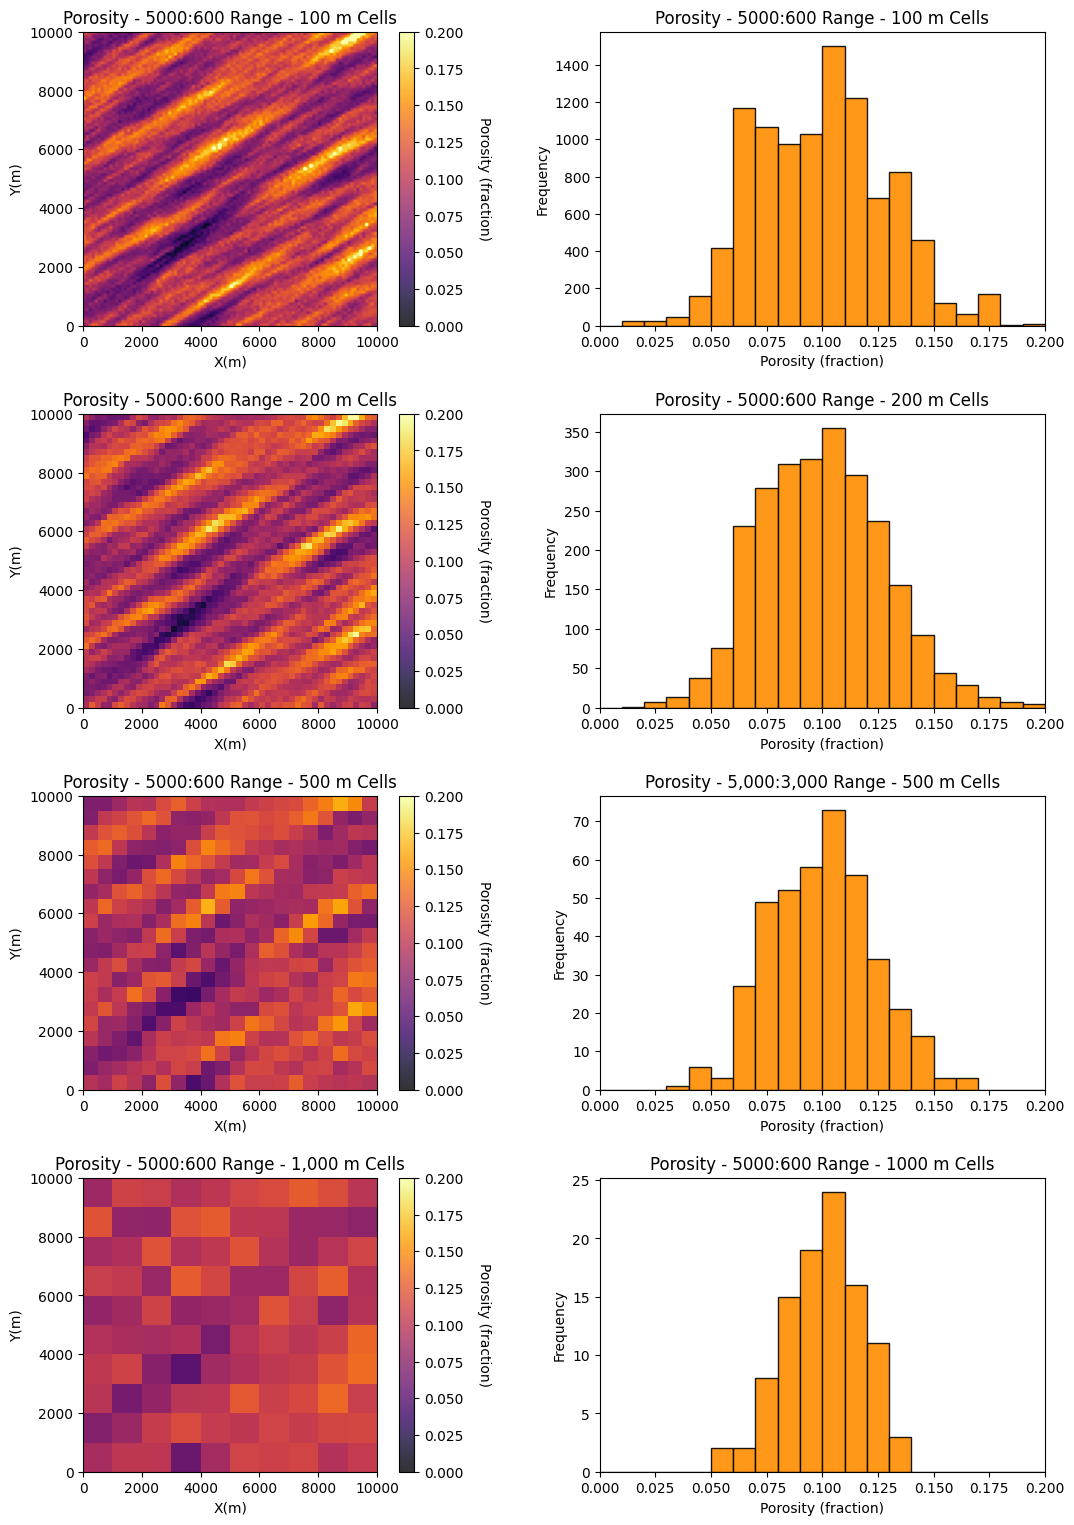

In [8]:
plt.subplot(421)
GSLIB.pixelplt_st(sim1,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 100 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(422)
GSLIB.hist_st(sim1.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 100 m Cells')

mid = upscale(sim1,new_nx = 50,new_ny = 50)

plt.subplot(423)
GSLIB.pixelplt_st(mid,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 200 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(424)
GSLIB.hist_st(mid.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 200 m Cells')

midb = upscale(sim1,new_nx = 20,new_ny = 20)

plt.subplot(425)
GSLIB.pixelplt_st(midb,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 500 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(426)
GSLIB.hist_st(midb.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - 5,000:3,000 Range - 500 m Cells')

course = upscale(sim1,new_nx = 10,new_ny = 10)

plt.subplot(427)
GSLIB.pixelplt_st(course,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 1,000 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(428)
GSLIB.hist_st(course.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + str(range_maj1) + ':' + str(range_min1) + ' Range - 1000 m Cells')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=3.0, wspace=0.3, hspace=0.3)
#plt.savefig('sim1_scale_change.tif',dpi=300,bbox_inches="tight")
plt.show()

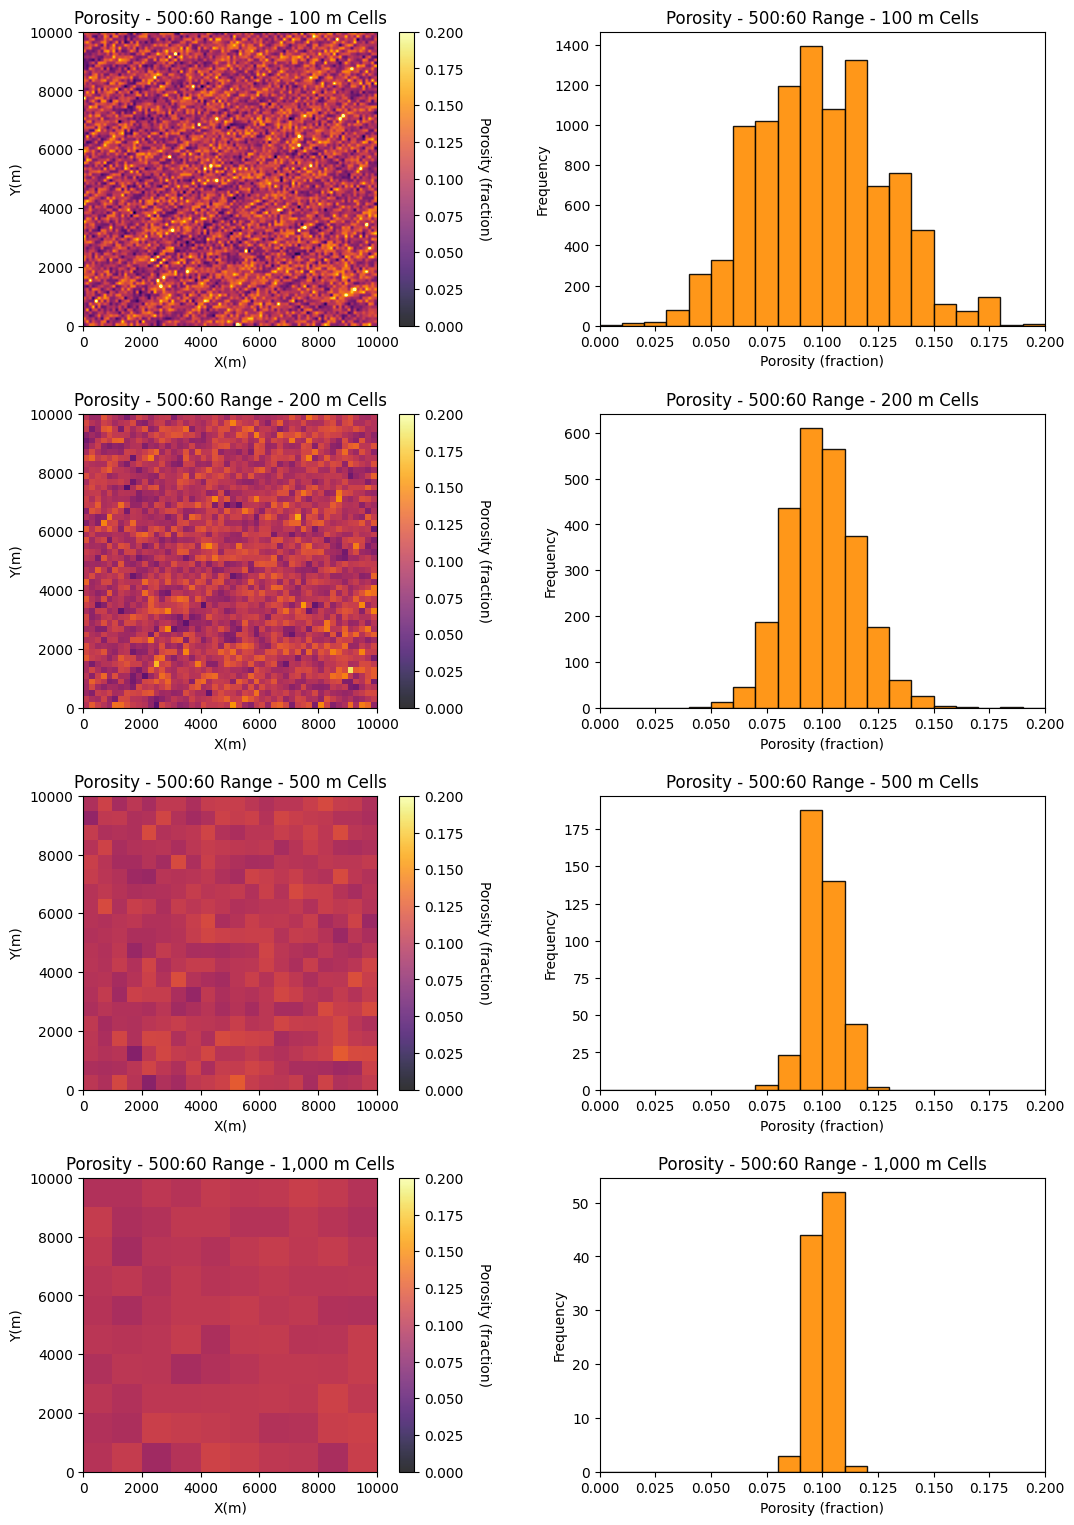

In [9]:
plt.subplot(421)
GSLIB.pixelplt_st(sim2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 100 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(422)
GSLIB.hist_st(sim2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 100 m Cells')

mid2 = upscale(sim2,new_nx = 50,new_ny = 50)

plt.subplot(423)
GSLIB.pixelplt_st(mid2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 200 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(424)
GSLIB.hist_st(mid2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 200 m Cells')

midb2 = upscale(sim2,new_nx = 20,new_ny = 20)

plt.subplot(425)
GSLIB.pixelplt_st(midb2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 500 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(426)
GSLIB.hist_st(midb2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 500 m Cells')

course2 = upscale(sim2,new_nx = 10,new_ny = 10)

plt.subplot(427)
GSLIB.pixelplt_st(course2,xmin,xmax,ymin,ymax,-1,0,.2,'Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 1,000 m Cells',"X(m)","Y(m)","Porosity (fraction)",cmap)

plt.subplot(428)
GSLIB.hist_st(course2.flatten(),0,.2,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity (fraction)",title='Porosity - ' + str(range_maj2) + ':' + str(range_min2) + ' Range - 1,000 m Cells')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.6, top=3.0, wspace=0.3, hspace=0.3)
#plt.savefig('sim2_scale_change.tif',dpi=300,bbox_inches="tight")
plt.show()

#### Relationship Between Scale and Dispersion

Let's loop over multiple upscaled grid cell sizes and calculate the resulting variance and standard deviation and then plot it up.

* observe the change in dispersion with change in scale, volume-variance relations

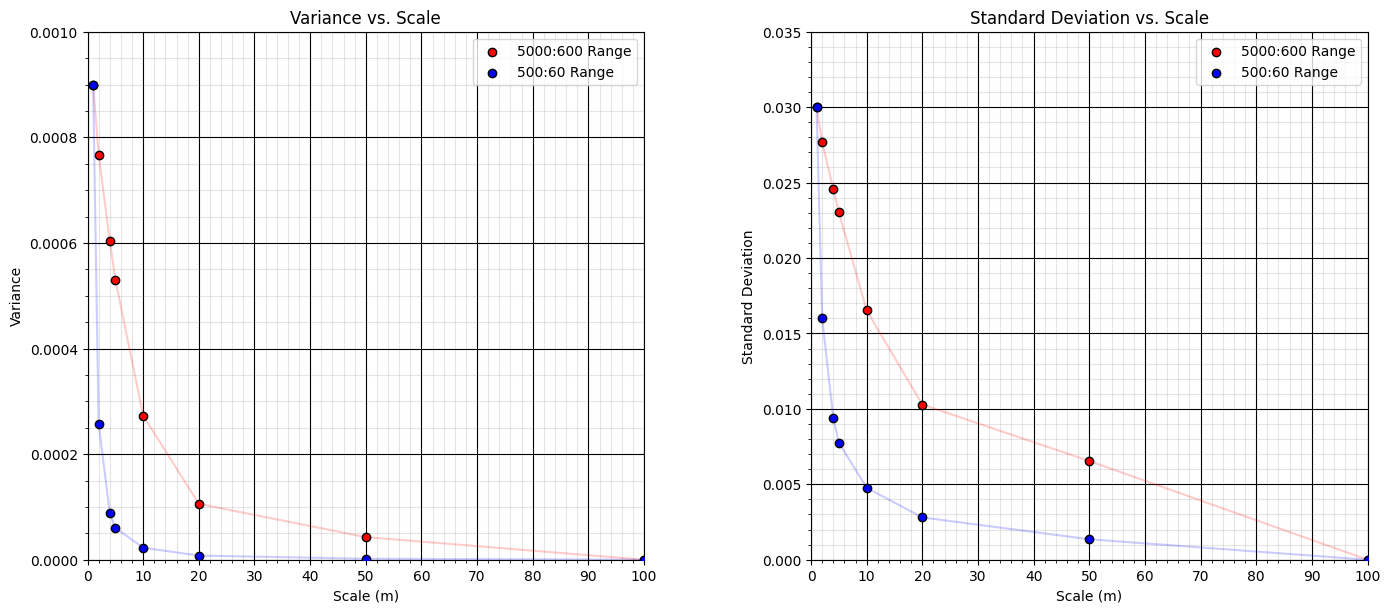

In [10]:
scale = []; var1 = []; var2 = []; std1 = []; std2 = []; ns = [50,25,20,10,5,2,1]
scale.append(1.0); var1.append(np.var(sim1)); var2.append(np.var(sim2)); std1.append(np.std(sim1)); std2.append(np.std(sim2))
for i,nc in enumerate(ns):
    scale.append(100/nc)
    scale1 = upscale(sim1,new_nx = nc,new_ny = nc)
    scale2 = upscale(sim2,new_nx = nc,new_ny = nc)
    var1.append(np.var(scale1)); var2.append(np.var(scale2))
    std1.append(np.std(scale1)); std2.append(np.std(scale2))

plt.subplot(121)
    
plt.plot(scale,var1,color='red',zorder=1,alpha=0.2)
plt.scatter(scale,var1,color='red',edgecolor='black',zorder=100,label=str(range_maj1) + ':' + str(range_min1) + ' Range')

plt.plot(scale,var2,color='blue',zorder=1,alpha=0.2)
plt.scatter(scale,var2,color='blue',edgecolor='black',zorder=100,label=str(range_maj2) + ':' + str(range_min2) + ' Range')
plt.xlim([0,100]); plt.ylim([0,0.001]); plt.xlabel('Scale (m)'); plt.ylabel('Variance')
plt.grid(which='major',axis='both',color='black'); plt.grid(which='minor',axis='both',color='grey',alpha=0.2)
plt.legend(loc = 'upper right'); plt.title('Variance vs. Scale')
plt.gca().xaxis.set_major_locator(MultipleLocator(10));plt.gca().xaxis.set_minor_locator(MultipleLocator(2));  # set the major ticks aligned with the bins
plt.gca().yaxis.set_major_locator(MultipleLocator(0.0002)); plt.gca().yaxis.set_minor_locator(MultipleLocator(0.00005)) 

plt.subplot(122)
    
plt.plot(scale,std1,color='red',zorder=1,alpha=0.2)
plt.scatter(scale,std1,color='red',edgecolor='black',zorder=100,label=str(range_maj1) + ':' + str(range_min1) + ' Range')

plt.plot(scale,std2,color='blue',zorder=1,alpha=0.2)
plt.scatter(scale,std2,color='blue',edgecolor='black',zorder=100,label=str(range_maj2) + ':' + str(range_min2) + ' Range')
plt.xlim([0,100]); plt.ylim([0,0.035]); plt.xlabel('Scale (m)'); plt.ylabel('Standard Deviation')
plt.grid(which='major',axis='both',color='black'); plt.grid(which='minor',axis='both',color='grey',alpha=0.2)
plt.legend(loc = 'upper right'); plt.title('Standard Deviation vs. Scale')

plt.gca().xaxis.set_major_locator(MultipleLocator(10));plt.gca().xaxis.set_minor_locator(MultipleLocator(2));  # set the major ticks aligned with the bins
plt.gca().yaxis.set_major_locator(MultipleLocator(0.005)); plt.gca().yaxis.set_minor_locator(MultipleLocator(0.001)) 

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.1, wspace=0.3, hspace=0.2)
#plt.savefig('plot_scale_change.tif',dpi=300,bbox_inches="tight")
plt.show()


#### Comments

This was a basic demonstration empirical scaling to demonstrate volume variance relations. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  